### 참고 내용
위도, 경도로 거리계산 : https://m.blog.naver.com/wideeyed/221406744173

가중치 논문 : https://www.dbpia.co.kr/journal/articleDetail?nodeId=NODE07500343

In [23]:
import pandas as pd
import geopandas as gpd
import sys
sys.path.append("../src/")

from utils import *

import warnings
warnings.filterwarnings("ignore")

In [24]:
## 읍면동 공간데이터 불러오기
emd = gpd.read_file(
    "../data/emd_20230729/emd.shp", 
    encoding="cp949", 
    )
emd = emd[emd["EMD_CD"].apply(lambda x: x[:2] == "48")]
emd = emd.set_crs(crs="EPSG:5179")
emd.head()

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry
4147,48121101,Buk-dong,북동,"POLYGON ((1102045.846 1697454.541, 1102056.067..."
4148,48121102,Jung-dong,중동,"POLYGON ((1102971.896 1696610.962, 1102967.906..."
4149,48121103,Seosang-dong,서상동,"POLYGON ((1101865.625 1697403.568, 1101867.528..."
4150,48121104,Sodap-dong,소답동,"POLYGON ((1101600.798 1698518.248, 1101652.825..."
4151,48121105,Dogye-dong,도계동,"POLYGON ((1102967.906 1696606.655, 1102971.896..."


In [25]:
## 노인 밀집 구역
silver = pd.read_csv(
    filepath_or_buffer="../data/silver.csv"
)
silver = silver.dropna()
silver = gpd.GeoDataFrame(
    silver, 
    geometry=gpd.points_from_xy(silver['경도'], silver['위도'])
    ).set_crs(crs="EPSG:4326").to_crs(epsg=5179)
silver = silver.reset_index(drop=True)

In [26]:
## 시설 위치
facility = pd.read_csv(
    filepath_or_buffer="../data/facility.csv"
)

# facility = facility[facility["주소"].apply(lambda x: "산청군" not in x)]
# facility = facility[facility["주소"].apply(lambda x: "한산면" not in x)]
# facility = facility[facility["주소"].apply(lambda x: "금남면 대도길" not in x)]

facility = facility.dropna()
facility = gpd.GeoDataFrame(
    facility, 
    geometry=gpd.points_from_xy(facility['경도'], facility['위도'])
    ).set_crs(crs="EPSG:4326").to_crs(epsg=5179)
facility = facility.reset_index(drop=True)

In [27]:
## 버스 정류장 위치 데이터
busstop = pd.read_csv(
    filepath_or_buffer="../data/busstop_weight.csv", 
    #encoding="cp949"
)

# def cityname_preprocessor(x): 
#     x_ = x.split()
#     if x_[1] == "마산시" or x_[1] == "진해시":
#         x_[1] = "창원시"
#     return x_[1]

# busstop = busstop[busstop["도시명"].apply(lambda x: True if "경상남도" in x else False)]
# busstop["도시명"] = busstop["도시명"].apply(lambda x: cityname_preprocessor(x))

# ## 이상치 및 결측치 처리
# busstop = busstop.drop(index=94785)
# busstop.loc[140553, "위도"] = 34.927810
# busstop.loc[140553, "경도"] = 128.06807
# busstop.loc[140554, "위도"] = 34.927663
# busstop.loc[140554, "경도"] = 128.06838

# # busstop_usecol = ["정류장명", "위도", "경도", "도시명"]
# busstop = busstop.reset_index(drop=True) # [busstop_usecol]

## geo data 형태로 변형
busstop = gpd.GeoDataFrame(
    busstop, 
    geometry=gpd.points_from_xy(busstop['경도'], busstop['위도'])
    )

## crs값 설정
busstop = busstop.set_crs(crs="EPSG:4326")
busstop = busstop.to_crs(epsg=5179)

In [28]:
busstop["도시명"].unique()

array(['경상남도 창원시', '경상남도 거제시', '경상남도 김해시', '경상남도 양산시', '경상남도 진주시',
       '경상남도 함양군', '경상남도 거창군', '경상남도 합천군', '경상남도 사천시', '경상남도 하동군',
       '경상남도 밀양시', '경상남도 통영시', '경상남도 마산시', '경상남도 함안군', '경상남도 창녕군',
       '경상남도 진해시', '경상남도 의령군', '경상남도 남해군', '경상남도 고성군'], dtype=object)

In [29]:
# ## busstop데이터의 point만 추출
# busstop_points = busstop[["geometry"]]
# ## emd데이터의 polygon만 추출
# emd_polygons = emd[["geometry"]]

# ## 공간 join 수행 (points와 polygons 간의 'within' 관계를 기반으로)
# busstop_within_emd = gpd.sjoin(
#     left_df=busstop_points, 
#     right_df=emd_polygons, 
#     how='inner', 
#     predicate='within'
#     )

# ## joined DataFrame에는 points와 일치하는 polygons의 정보가 포함됨
# busstop_within_emd = busstop_within_emd.drop(columns='index_right')

# ## 원본 버스 정류장 데이터에 조인
# busstop_within_emd = gpd.sjoin(
#     left_df=busstop, 
#     right_df=busstop_within_emd, 
#     how="right"
#     ).drop(columns='index_left')
# busstop_within_emd = busstop_within_emd.reset_index(drop=True)

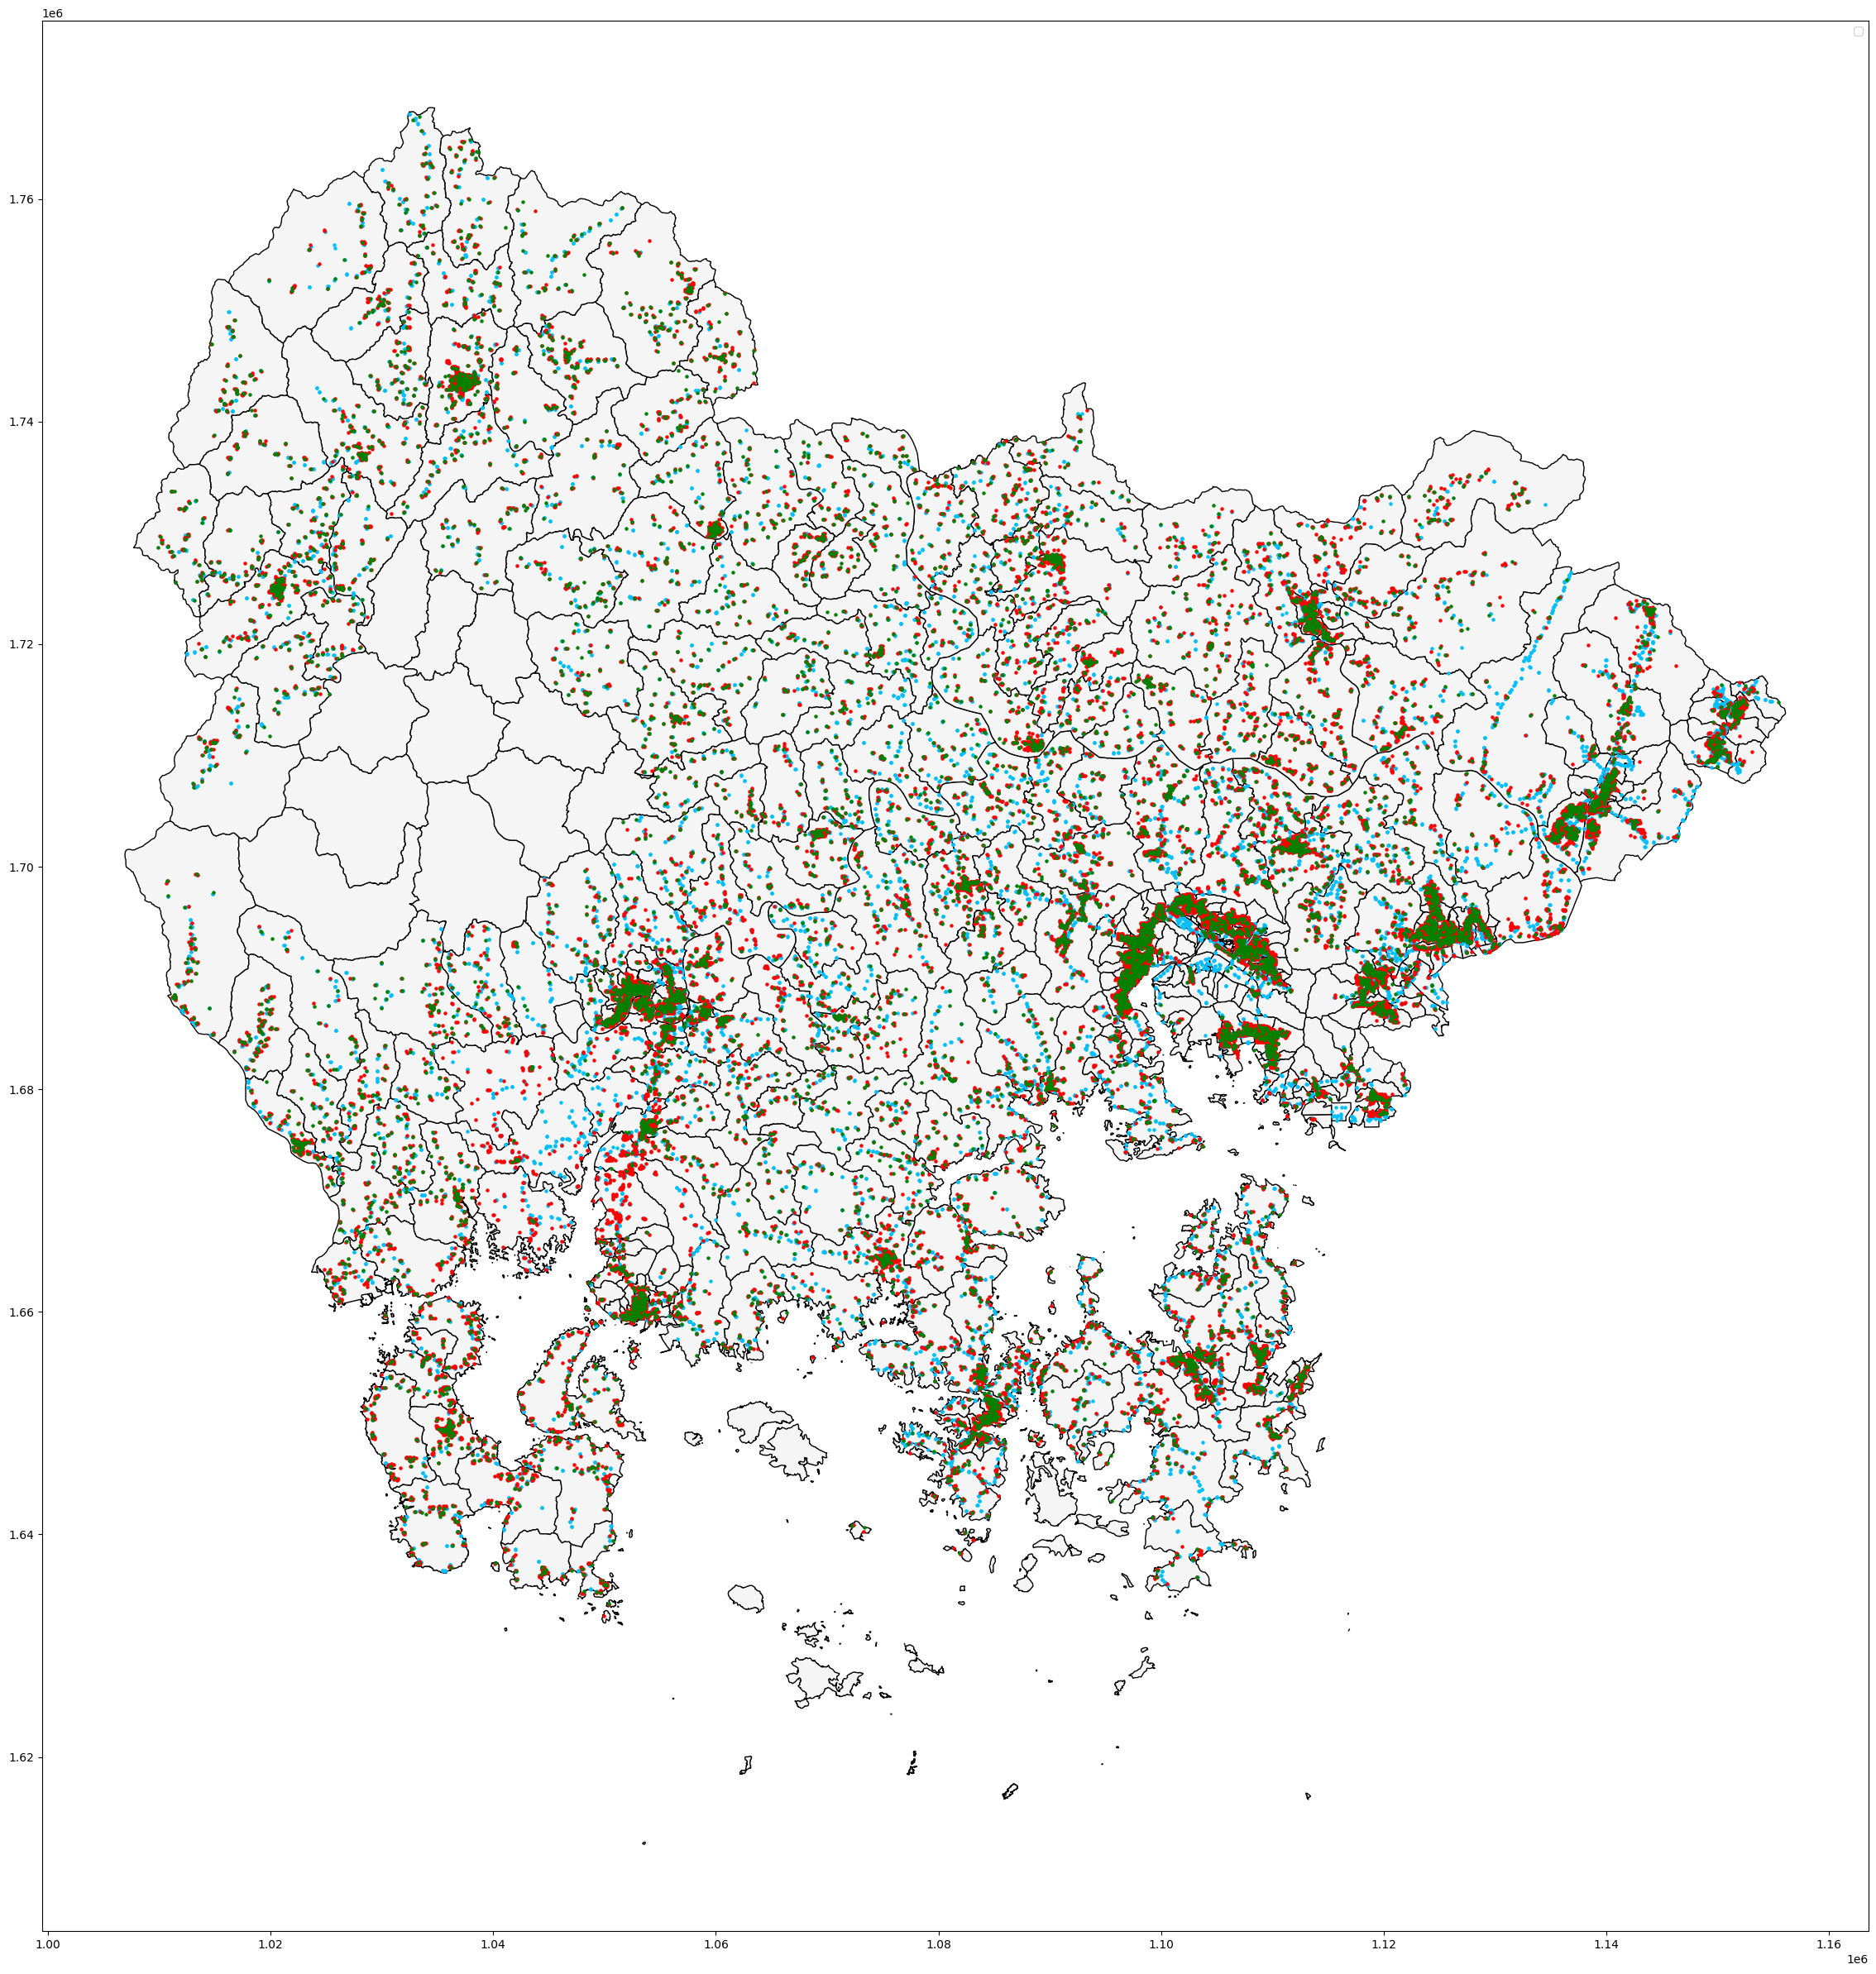

In [31]:
import matplotlib.pyplot as plt
## 읍면동 틀 그리기
ax = emd.plot(
    figsize = (30, 30), 
    color = "whitesmoke", 
    edgecolor = "black", 
    linewidth = 1,
    column = "EMD_KOR_NM",
    legend = True, 
    categorical = True
)

## 버스 정류장 위치 확인
busstop.plot(
    ax = ax, 
    color = "deepskyblue", 
    markersize = 5
)
## 노인 위치 확인
silver.plot(
    ax = ax, 
    color = "red", 
    markersize = 5
)
## 시설 위치 확인
facility.plot(
    ax = ax, 
    color = "green", 
    markersize = 5
)
plt.legend()
plt.show()

### 거리 계산

### 1. 노인 위치 <--> 버스 정류장

In [32]:
import numpy as np
from scipy.spatial import KDTree
import pandas as pd

# KD-Tree 생성
silver_tree = KDTree(busstop[["경도", "위도"]])

# 격자 위치마다 근접한 k개의 버스 정류장 찾기
silver_k = 10
silver_distances, silver_indices = silver_tree.query(silver[["경도", "위도"]], k=silver_k)

# 결과 출력
silver_results = []
for i, (distance, index) in enumerate(zip(silver_distances, silver_indices)):
    result = {
        '격자 위치': silver.index[i],
        '근접 버스 정류장': busstop.iloc[index],
        '거리': distance
    }
    silver_results.append(result)

silver_results_df = pd.DataFrame(silver_results)

In [33]:
import pickle

with open("../data/거리계산/silver_calc_result_df.pkl", "wb") as f:
    pickle.dump(silver_results_df, f)

In [35]:
busstop

,nodeid,정류장명,위도,경도,정보수집일,모바일단축번호,도시코드,도시명,관리도시명,geometry,weight
0,CWB379000566,구암고등학교,35.246296,128.593978,2023-10-16,420615.0,38010,경상남도 창원시,창원,POINT (1099529.31 1695090.322),478654.0
1,CWB379000567,사격장입구,35.244923,128.683156,2023-10-16,107508.0,38010,경상남도 창원시,창원,POINT (1107644.846 1695031.102),464401.0
2,CWB379000568,장애인복지회관입구,35.244960,128.673597,2023-10-16,119117.0,38010,경상남도 창원시,창원,POINT (1106775.068 1695024.86),732161.0
3,CWB379000570,장애인복지회관입구,35.244773,128.673243,2023-10-16,119118.0,38010,경상남도 창원시,창원,POINT (1106743.105 1695003.68),266638.0
4,CWB379000573,지귀상가,35.244778,128.659437,2023-10-16,119111.0,38010,경상남도 창원시,창원,POINT (1105486.945 1694989.456),1120637.0
...,...,...,...,...,...,...,...,...,...,...,...
18854,YSB5166,사과나무집,35.491970,128.989600,2023-10-16,5166.0,38100,경상남도 양산시,양산,POINT (1135114.889 1722807.741),3171.0
18855,YSB5167,이지더원3차,35.322630,129.027700,2023-10-16,5167.0,38100,경상남도 양산시,양산,POINT (1138861.264 1704077.947),147088.0
18856,YSB5168,반도유보라6차,35.317890,129.027500,2023-10-16,5168.0,38100,경상남도 양산시,양산,POINT (1138851.189 1703551.929),147088.0
18857,YSB5169,양우내안애6차,35.318010,129.023400,2023-10-16,5169.0,38100,경상남도 양산시,양산,POINT (1138478.261 1703559.5),147088.0


In [36]:
# KD-Tree를 사용하여 각 노인 위치에서 가장 가까운 10개의 버스 정류장을 찾기
silver_values = silver[['위도', '경도']].values
busstop_within_emd_values = busstop[['위도', '경도']].values

tree = KDTree(busstop_within_emd_values)
k = 10
distances, indices = tree.query(silver_values, k=k)

# 결과 데이터프레임 생성
dist_result_columns = ["격자이름"] + [f'정류장{i+1}' for i in range(k)]
dist_results = []
location_results = {}
for i in range(len(silver)):
    row1 = [silver.loc[i, 'gid']]
    row2 = []
    for j in indices[i]:
        row1.append(
            GeoUtil.get_harversion_distance(
                busstop.loc[j, '경도'], 
                busstop.loc[j, '위도'], 
                silver.loc[i, '경도'], 
                silver.loc[i, '위도']
                )
            )
        row2.append(busstop.loc[j, :])
    location_results[silver.loc[i, 'gid']] = row2
    dist_results.append(row1)

silver_dist_result = pd.DataFrame(dist_results, columns=dist_result_columns)

In [37]:
pd.DataFrame(location_results["마라008419"])

,nodeid,정류장명,위도,경도,정보수집일,모바일단축번호,도시코드,도시명,관리도시명,geometry,weight
4465,GJB553,탑포마을입구,34.766597,128.601618,2023-10-16,3308.0,38090,경상남도 거제시,거제,POINT (1100811.294898206 1641897.6798886764),31909.0
4460,GJB547,탑포입구,34.766598,128.601558,2023-10-16,3302.0,38090,경상남도 거제시,거제,POINT (1100805.8019212065 1641897.8037735135),3754.0
4598,GJB590,탑포마을입구,34.767218,128.603167,2023-10-16,3345.0,38090,경상남도 거제시,거제,POINT (1100952.2357299766 1641968.1763137793),22126.0
4466,GJB554,탑포마을입구,34.767143,128.603305,2023-10-16,3309.0,38090,경상남도 거제시,거제,POINT (1100964.9863856295 1641959.9978920512),31147.0
4459,GJB546,탑포삼거리,34.769012,128.602109,2023-10-16,3301.0,38090,경상남도 거제시,거제,POINT (1100853.2820886825 1642165.9841728713),31147.0
4599,GJB591,탑포사거리(부춘),34.769156,128.602505,2023-10-16,3346.0,38090,경상남도 거제시,거제,POINT (1100889.3471283293 1642182.4245169382),5836.0
3478,GJB1805,탑포사거리(율포),34.769370,128.602396,2023-10-16,5408.0,38090,경상남도 거제시,거제,POINT (1100879.0959372704 1642206.0717100613),44445.0
4464,GJB552,탑포마을,34.762772,128.599258,2023-10-16,3307.0,38090,경상남도 거제시,거제,POINT (1100599.9583504794 1641471.1251434963),31909.0
3669,GJB1833,탑포마을회관,34.762914,128.597417,2023-10-16,3356.0,38090,경상남도 거제시,거제,POINT (1100431.2389132492 1641485.0525175673),33786.0
4458,GJB545,율포솔곶이,34.772387,128.598268,2023-10-16,5322.0,38090,경상남도 거제시,거제,POINT (1100497.6965299447 1642536.429495983),28360.0


In [38]:
with open("../data/거리계산/silver_dist_result_df.pkl", "wb") as f:
    pickle.dump(silver_dist_result, f)
    
with open("../data/거리계산/silver_location_results.pkl", "wb") as f:
    pickle.dump(location_results, f)

In [39]:
silver_dist_result[[f'정류장{i+1}' for i in range(k)]] = silver_dist_result[[f'정류장{i+1}' for i in range(k)]] * 1000

In [41]:
silver_dist_result.sort_values(by="정류장1", ascending=False)

,격자이름,정류장1,정류장2,정류장3,정류장4,정류장5,정류장6,정류장7,정류장8,정류장9,정류장10
22433,라라722407,8648.09,8658.52,8766.63,8770.88,8754.12,8816.14,8826.48,8794.57,8801.61,8988.94
21981,라라732402,8591.84,8602.99,8729.37,8758.90,8761.81,8727.66,8803.01,8735.48,8814.39,8825.97
21910,라라723408,8509.56,8520.01,8629.52,8633.73,8616.48,8678.87,8689.25,8655.80,8662.85,8851.83
21860,라라819382,3824.25,3884.25,3836.02,3901.23,4109.92,4117.58,4266.30,4278.78,4605.86,4297.23
21940,라라819383,3727.94,3784.98,3739.65,3801.96,4028.77,4036.38,4176.09,4188.69,4505.63,4518.62
...,...,...,...,...,...,...,...,...,...,...,...
20564,라라912924,1.51,16.81,277.97,357.58,353.38,391.75,398.50,610.47,634.40,644.68
517,마라013551,1.25,33.87,52.68,102.83,111.10,123.74,254.17,279.84,356.99,440.07
4187,마마128014,1.05,6.24,20.44,33.34,168.45,178.51,234.50,206.06,247.03,207.36
9063,마마151084,0.60,7.19,1116.17,1119.79,1297.17,1305.72,1483.35,1489.62,1391.64,1396.79


### 2. 시설 위치 <--> 버스 정류장

In [42]:
# KD-Tree 생성
facility_tree = KDTree(busstop_within_emd[["경도", "위도"]])

# 격자 위치마다 근접한 k개의 버스 정류장 찾기
facility_k = 10
facility_distances, facility_indices = facility_tree.query(facility[["경도", "위도"]], k=facility_k)

# 결과 출력
facility_results = []
for i, (distance, index) in enumerate(zip(facility_distances, facility_indices)):
    result = {
        '격자 위치': facility.index[i],
        '근접 버스 정류장': busstop_within_emd.iloc[index],
        '거리': distance
    }
    facility_results.append(result)

facility_results_df = pd.DataFrame(facility_results)

In [47]:
facility_results_df["근접 버스 정류장"][0]

,nodeid,정류장명,위도,경도,정보수집일,모바일단축번호,도시코드,도시명,관리도시명,weight,geometry
4791,GJB309,소방서,34.895763,128.686470,2023-10-16,2623.0,38090,경상남도 거제시,거제,32570.0,POINT (1108407.168 1656310.878)
4806,GJB324,소방서,34.896165,128.686740,2023-10-16,2629.0,38090,경상남도 거제시,거제,56974.0,POINT (1108431.311 1656355.716)
5940,GJB944,거제소방서,34.895285,128.686123,2023-10-16,2632.0,38090,경상남도 거제시,거제,32819.0,POINT (1108376.12 1656257.454)
5729,GJB825,거제소방서,34.895302,128.685887,2023-10-16,2631.0,38090,경상남도 거제시,거제,51798.0,POINT (1108354.473 1656259.047)
4805,GJB323,거제경찰서,34.897543,128.686800,2023-10-16,2639.0,38090,경상남도 거제시,거제,56974.0,POINT (1108434.982 1656508.642)
4792,GJB310,거제경찰서,34.897955,128.686875,2023-10-16,2638.0,38090,경상남도 거제시,거제,38391.0,POINT (1108441.293 1656554.378)
4793,GJB311,한신APT,34.898080,128.688038,2023-10-16,2624.0,38090,경상남도 거제시,거제,32570.0,POINT (1108547.424 1656569.502)
4804,GJB322,한신APT,34.898228,128.687982,2023-10-16,2628.0,38090,경상남도 거제시,거제,56974.0,POINT (1108542.052 1656585.89)
5939,GJB943,옥포마리나APT,34.893507,128.687520,2023-10-16,2637.0,38090,경상남도 거제시,거제,30299.0,POINT (1108506.078 1656061.746)
4175,GJB1806,옥포시립테니스장,34.899401,128.686356,2023-10-16,2656.0,38090,경상남도 거제시,거제,60255.0,POINT (1108391.988 1656714.223)


In [48]:
import pickle

with open("../data/거리계산/facility_calc_result_df.pkl", "wb") as f:
    pickle.dump(facility_results_df, f)

In [49]:
# KD-Tree를 사용하여 각 노인 위치에서 가장 가까운 10개의 버스 정류장을 찾기
facility_values = facility[['위도', '경도']].values
busstop_within_emd_values = busstop_within_emd[['위도', '경도']].values

tree = KDTree(busstop_within_emd_values)
k = 10
distances, indices = tree.query(facility_values, k=k)

# 결과 데이터프레임 생성
dist_result_columns = ["시설명"] + [f'정류장{i+1}' for i in range(k)]
dist_results = []
facility_location_results = {}
for i in range(len(facility)):
    row1 = [facility.loc[i, '시설명']]
    row2 = []
    for j in indices[i]:
        row1.append(
            GeoUtil.get_harversion_distance(
                busstop_within_emd.loc[j, '경도'], 
                busstop_within_emd.loc[j, '위도'], 
                facility.loc[i, '경도'], 
                facility.loc[i, '위도']
                )
            )
        row2.append(busstop_within_emd.loc[j, :])
    facility_location_results[facility.loc[i, '시설명']] = row2
    dist_results.append(row1)

facility_dist_result = pd.DataFrame(dist_results, columns=dist_result_columns)

In [50]:
pd.DataFrame(facility_location_results["거제소방서"])

,nodeid,정류장명,위도,경도,정보수집일,모바일단축번호,도시코드,도시명,관리도시명,weight,geometry
4791,GJB309,소방서,34.895763,128.686470,2023-10-16,2623.0,38090,경상남도 거제시,거제,32570.0,POINT (1108407.1678994535 1656310.877735662)
4806,GJB324,소방서,34.896165,128.686740,2023-10-16,2629.0,38090,경상남도 거제시,거제,56974.0,POINT (1108431.3109710042 1656355.7163199068)
5940,GJB944,거제소방서,34.895285,128.686123,2023-10-16,2632.0,38090,경상남도 거제시,거제,32819.0,POINT (1108376.1196025277 1656257.4544500038)
5729,GJB825,거제소방서,34.895302,128.685887,2023-10-16,2631.0,38090,경상남도 거제시,거제,51798.0,POINT (1108354.4730026461 1656259.047082307)
4805,GJB323,거제경찰서,34.897543,128.686800,2023-10-16,2639.0,38090,경상남도 거제시,거제,56974.0,POINT (1108434.98169226 1656508.6416748487)
4792,GJB310,거제경찰서,34.897955,128.686875,2023-10-16,2638.0,38090,경상남도 거제시,거제,38391.0,POINT (1108441.2934473718 1656554.3781793043)
4793,GJB311,한신APT,34.898080,128.688038,2023-10-16,2624.0,38090,경상남도 거제시,거제,32570.0,POINT (1108547.4243287668 1656569.5015493198)
4804,GJB322,한신APT,34.898228,128.687982,2023-10-16,2628.0,38090,경상남도 거제시,거제,56974.0,POINT (1108542.0520521395 1656585.8903144135)
5939,GJB943,옥포마리나APT,34.893507,128.687520,2023-10-16,2637.0,38090,경상남도 거제시,거제,30299.0,POINT (1108506.0784742394 1656061.7456053833)
4175,GJB1806,옥포시립테니스장,34.899401,128.686356,2023-10-16,2656.0,38090,경상남도 거제시,거제,60255.0,POINT (1108391.9884327373 1656714.2226451987)


In [51]:
facility_dist_result

,시설명,정류장1,정류장2,정류장3,정류장4,정류장5,정류장6,정류장7,정류장8,정류장9,정류장10
0,거제소방서,0.05226,0.05264,0.09737,0.09872,0.16442,0.20989,0.27355,0.28356,0.31996,0.36085
1,거창소방서,0.89842,0.90520,0.80260,0.81512,0.92931,0.94131,0.99580,0.97819,1.00680,0.99246
2,고성소방서,0.38742,0.66234,0.67034,0.77830,0.78534,0.89163,0.89953,1.06463,1.06824,1.05006
3,김해동부소방서,0.04891,0.14006,0.26468,0.24016,0.24521,0.27720,0.41858,0.55399,0.59256,0.60060
4,김해서부소방서,0.11327,0.11122,0.11531,0.12826,0.27943,0.30672,0.30570,0.35095,0.30961,0.38560
...,...,...,...,...,...,...,...,...,...,...,...
18446,장성중앙시장,0.26668,0.26574,0.42969,0.43670,0.91955,0.92856,0.79412,0.79928,0.95447,0.96641
18447,홍천시장,0.01958,0.03213,0.22983,0.23771,0.78291,0.78934,0.99128,1.00245,0.84606,0.85844
18448,제주시동문재래시장,0.08293,0.08733,0.19476,0.19731,0.30435,0.30813,0.34238,0.34684,0.50832,0.51171
18449,마천분회경로당,0.04434,0.04811,0.13948,0.14475,0.18469,0.23637,0.30860,0.31748,0.43108,0.43375


In [52]:
with open("../data/거리계산/facility_dist_result_df.pkl", "wb") as f:
    pickle.dump(facility_dist_result, f)
    
with open("../data/거리계산/facility_location_results.pkl", "wb") as f:
    pickle.dump(facility_location_results, f)